# Power analysis requires normally distributed data

It has been proposed to use monte carlo-based power analyses to run t-tests on non-normally distributed data.

# One-Sample T-Test
The following is an example of the Student's T-Test in action. Simply stated, a Student's T-Test is a method for testing the hypothesis that a value (in a one-sample t-test) or a distribution (in two-sample independent t-test) is equal to a sample distribution obtained from  anormally distributed population. The t-test assumes normality, but is robust to moderate violations against this asumption such that a distributions with a reasonably sized volume of extreme outliers may render this test inadequate. The name "Student" refers to studentizing the residuals of a statistical model, which essential means to divide the residual by it's standard deviation. The t-distribution, which is an assumed normally distributed distribution of continuous data, is used in this test. More will be discussed on this test in later chapters.

Let's assume a nanufacturer sells a type of machine capable of producing 100,000 units per month with a standard deviation of 2,800 units. A company buys a number of these machines and has found them to only be producing 90,000 units. The company wants to know how many of the machines are needed to determine with a high level of confidence the machines are not capable of producing 100,000 units. The below power analysis indicates that for a t-test, a sample of three machines is required to prevent, with an 85% probability, failing to identify a statistically significant difference in actual versus marketed machine performance when there is one.

In [1]:
from statsmodels.stats.power import TTestPower

# Difference of distribution mean and the value to be assessed divided by the distribution standard deviation
effect_size = abs(100000-90000) / 2800
alpha = 0.05
nobs=3

powersTT = TTestPower()
result = powersTT.solve_power(effect_size, nobs=nobs, alpha=alpha, alternative='two-sided')
print('Power based on sample size: {}'.format(round(result,2)))

Power based on sample size: 0.85


# Paired Sample T-Test

In the above example, the owners found a statistically significant difference. One engineer has hypothesized using a higher-viscosity oil will reduce excessive vibration and enable the machines to produce 100,000 units per month, which would produce a very simple solution to their problem. The company desires the same level of hypothesis testing power as before (0.85) and wants to know how many samples are required for this. By testing different observation numbers, below, we are able to identify 11 machines with lower-viscosity oil and 11 machines with higher-viscosity oil (this is the "paired" version of the t-test) are required to prevent the engineer from failing to find that the higher-viscosity oil does in fact produce 10,000 additional units, as intended, when that is the correct result.

In [1]:
from statsmodels.stats.power import TTestPower
import matplotlib.pyplot as plt
import numpy as np

# Difference from null hypothesis that there is no difference
effect_size = abs(0-10000) / 10000
alpha = 0.05
nobs=np.linspace(start=5, stop=14, num=10, dtype = int)

powers = TTestPower()

[print('Power based on {} samples: {:.2f}'.format(nob,
                                                 powers.solve_power(effect_size,
                                                                          nobs=nob,
                                                                          alpha=alpha,
                                                                          alternative='two-sided')))
 for nob in nobs];

Power based on 5 samples: 0.40
Power based on 6 samples: 0.51
Power based on 7 samples: 0.60
Power based on 8 samples: 0.68
Power based on 9 samples: 0.75
Power based on 10 samples: 0.80
Power based on 11 samples: 0.85
Power based on 12 samples: 0.88
Power based on 13 samples: 0.91
Power based on 14 samples: 0.93


In the power plot below, we can see as sample size increases, statistical power does as well. This is due to the assumption that as sample size increases, standard deviation (distributional error) decreases. As such, the results of the test applied have lower margins of error.

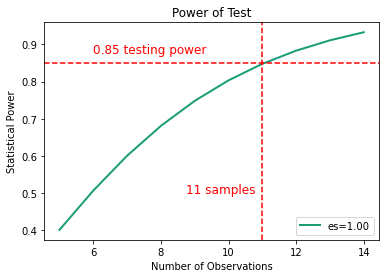

In [2]:
powers.plot_power(dep_var='nobs', nobs=nobs, effect_size=[abs(0-10000) / 10000])
plt.axhline(0.85, color='red', linestyle='--')
plt.axvline(11, color='red', linestyle='--')
plt.annotate('0.85 testing power', xy=(6,0.875), color='red', fontsize=12)
plt.annotate('11 samples', xy=(8.75,0.5), color='red', fontsize=12)
plt.ylabel('Statistical Power')
plt.savefig('./powerplot1.png', dpi=300, facecolor='w', bbox_inches = "tight")

plt.show()

# Two-Sample Independent T-Test with Pooled Variance
## Difference of Means
This is to compare to sample distribution means using a pooled standard deviation with different sample sizes. Pooled standard deviation means the two sample distributions are assumed to have approximately the same standard deviation. The standard deviations are pooled due to having different sample sizes, which are assumed to explain any minor difference in standard deviations. By contrast, you would not pool standard deviations if the sample sizes were very different, but it was assumed the two distributions do not have similar standard deviations. For example, standard deviation of growth rates of volatile stocks versus those of 30-year US Treasury bonds would be assumed to have very different standard deviations.

To expand more on pooling standard deviations, pooling assumes the sample data from which the two individual standard deviations are calculated come from populations that have roughly the same standard deviation. This can be ambiguous at times. Penn State University has mentioned a good rule of thumb for determining if sample standard deviations are poolable is if neither is greater than between roughly 0.5 and 2 times the size of the other. If sample sizes are very small, they should be equal. This is up to the researcher's judgment. https://online.stat.psu.edu/stat500/lesson/7/7.3/7.3.1/7.3.1.1

**HERE is the formula for standard deviation, where s is the sample standard deviation and s squared is the sample variance. n is for observation size**

In [1]:
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
import numpy as np
import math

df_prof = sm.datasets.get_rdataset("Salaries", "carData").data

df_prof_A = df_prof.loc[df_prof['discipline'] == 'A']
df_prof_B = df_prof.loc[df_prof['discipline'] == 'B']

df_duncan = sm.datasets.get_rdataset("Duncan", "carData").data

df_duncan.loc[df_duncan['type'] == 'prof', 'type'] = 'professional'
df_duncan.loc[df_duncan['type'] == 'wc', 'type'] = 'white-collar'
df_duncan.loc[df_duncan['type'] == 'bc', 'type'] = 'blue-collar'

df_professional = df_duncan.loc[(df_duncan['type'] == 'professional')]
df_blue_collar = df_duncan.loc[(df_duncan['type'] == 'blue-collar')]

def pooled_standard_deviation(dataset1, dataset2, column) -> float:
    pooledSD = math.sqrt(((len(dataset1) - 1)*(dataset1[column].std()**2) +
                          (len(dataset2) - 1)*(dataset2[column].std()**2)) / (len(dataset1) + len(dataset2) - 2))
    return pooledSD;

stdDeviation = pooled_standard_deviation(dataset1=df_prof_A,
                                         dataset2=df_prof_B,
                                         column='salary')

# In this case, effect size is Cohen's d, which is the difference of means divided by the pooled standard deviation
effect = abs(df_prof_B['salary'].mean() - df_prof_A['salary'].mean() ) / stdDeviation # The difference between two means divided by std if pooled 2-sample
alpha = 0.05
power = 0.8
ratio=len(df_prof_B) / len(df_prof_A) # # of obs in sample 2 relative (with respect) to sample 1 (sample 2 / sample 1)
# perform power analysis
powers = TTestIndPower()
result = powers.solve_power(effect, power=power, nobs1=None, ratio=ratio, alpha=alpha, alternative='two-sided')
print('Minimum Sample Size Required in Sample 1 (in this case, df_prof_A): {}'.format(math.ceil(result)))
print('Minimum Sample Size Required in Sample 2 (in this case, df_prof_B): {}'.format(math.ceil(result*ratio)))
print('Original Size of Sample 1: {}'.format(len(df_prof_A)))
print('Original Size of Sample 2: {}'.format(len(df_prof_B)))

if math.ceil(ratio) > len(df_prof_A):
    print('More samples needed in sample 2')
else:
    print('Sample 2 has an adequate sample size')

if math.ceil(result*ratio) > len(df_prof_B):
    print('More samples needed in sample 2')
else:
    print('Sample 2 has an adequate sample size')

Minimum Sample Size Required in Sample 1 (in this case, df_prof_A): 145
Minimum Sample Size Required in Sample 2 (in this case, df_prof_B): 173
Original Size of Sample 1: 181
Original Size of Sample 2: 216
Sample 2 has an adequate sample size
Sample 2 has an adequate sample size


## Pearson's Correlation
Suppose we want to identify if there is or is not a correlation of at least 0.9 between professional and blue-collar incomes using the Duncan dataset. We need to know how many samples are needed to perform this test and identify that level of correlation, if there is one. That correlation may exist, but it also may not. However, if we don't have at least the minimum number of observations required, we will never know. The same number of observations are required two calculate Pearson's Correlation Coefficient between two groups, so this is counted as an Independent T-Test Power Analysis. 

In [3]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import numpy as np
import math
# parameters for power analysis
effect = 0.9 # Correlation with 90% of variance in df_professional explained by df_blue_collar
alpha = 0.05
power = 0.8
ratio=1.0 # # of obs in sample 2 relative (with respect) to sample 1 (sample 2 / sample 1); must be 1.0 for Pearson's correlation
# perform power analysis
powers = TTestIndPower()
result = powers.solve_power(effect, power=power, nobs1=None, ratio=ratio, alpha=alpha, alternative='two-sided')
print('Minimum Sample Size Required in Each Group: {}'.format(math.ceil(result)))

Minimum Sample Size Required in Each Group: 21


Here we can see that as sample size increases, so does power, approximating effect size independence such that Type II error converges to zero.

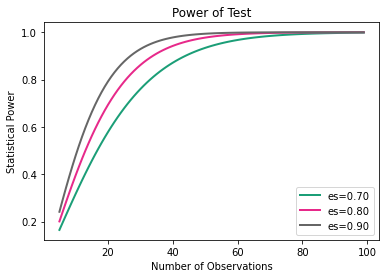

In [4]:
sample_sizes = np.array(range(5, 100))

powers.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=[0.7, 0.8, 0.9])
plt.ylabel('Statistical Power')
plt.savefig('./powerplot2.png', dpi=300, facecolor='w', bbox_inches = "tight")
plt.show()

# One-Sample Chi Square Test of Independence (not working in Statsmodels yet)
This test is used to determine if there is a relationship between two categorical features. This can also be used to check for correlation.

This is used to determine if there are an equal distribution of frequencies of values in a categorical column. Say for example, 100 phones were sold in a day, 85 were Apple, 10 were Samsung and 5 were Motorolla. This tells if there are enough samples to determine if there's enough data.

In [ ]:
from statsmodels.stats.power import _GofChisquareIndPower
# parameters for power analysis
effect_size = 
alpha = 0.05
power = 0.8

# perform power analysis
powerChiSqr = _GofChisquareIndPower()
result = powerChiSqr.solve_power(effect_size, power=power, nobs=None, alpha=alpha, n_bins)
print('Sample Size Required in Sample 1: {:.3f}'.format(result)) # nobs1 is the sample size. 
print('Sample Size Required in Sample 2: {:.3f}'.format(result*ratio)) # nobs2 is the sample size. 

# Pearson Chi-Square Goodness of Fit Test (One Sample; One Category)
The Chi-Square distribution is derived from the values of the ratio between sample variance and population variance of categorical variables. Chi-square distributions are non-negative and non-symmetric.

The Pearson Chi-Square Goodness of Fit Test assumes samples fall randomly into categorical bins. If, for example, there are 2 bins and 100 samples, it assumes each bin, by rules of random probability, will contain 50 samples. A statistically significant difference could be such that one bin has 95 samples and another has 5 following sample disbursement. The power test in this section identifies the quantity of samples - based on the number of categorical bins - would be required to prevent Type II error.

Let's use an example such that a phone vendor sells four popular brands of phones, brands A, B, C, and D. We want to determine out how many samples are required to produce a power of 0.8 so we can understand if there is a statistically significant difference in popularity of phones so the vendor can more properly invest in phone aquisitions. In this case, the null hypothesis asserts that 25% phones of each brand are sold. In reality, 20% of phones sold were brand A, 30% were brand B, 19% were brand C, and 31% were brand D phones.

Testing different values for the nobs argument (number of observations), we find that a minimum of 224 samples produces a power just greater than 0.801. Adding more samples will only improve this. If the true distribution were more divergent from the hypothesized 25% even split, fewer samples would be required. However, since the splits are relatively close to 25%, a high volume of samples is needed.

In [1]:
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.gof import chisquare_effectsize

# probs0 asserts 25% of each brand are sold
# In reality, 12% of Brand A, 25% of Brand B, 33% sold were Brand C, and 1% were Brand D. 
effect_size = chisquare_effectsize(probs0=[25, 25, 25, 25], probs1=[20, 30, 19, 31], cohen=True)
alpha = 0.05
n_bins=4 # 4 brands of phones

analysis = GofChisquarePower()
result = analysis.solve_power(effect_size, nobs=224, alpha=alpha, n_bins=n_bins)
print('Sample Size Required in Sample 1: {:.3f}'.format(result))

Sample Size Required in Sample 1: 0.801


# Two-Population Z-Test with Pooled Variance
This is to compare two population means. This just tells if the populations are large enough to compare. If they're not, they can't be compared.

In [20]:
df_prof

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,Prof,B,19,18,Male,139750
1,Prof,B,20,16,Male,173200
2,AsstProf,B,4,3,Male,79750
3,Prof,B,45,39,Male,115000
4,Prof,B,40,41,Male,141500
...,...,...,...,...,...,...
392,Prof,A,33,30,Male,103106
393,Prof,A,31,19,Male,150564
394,Prof,A,42,25,Male,101738
395,Prof,A,25,15,Male,95329


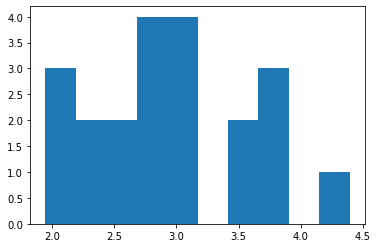

In [8]:
import matplotlib.pyplot as plt

plt.hist(df_prof_A['salarydf_blue_collar

Let us look at the dataset of salaries for professors of two different disciplines, discipline A and discipline B. We want to know if there is a statistically significant difference between them based on the data we have. First, we need to perform a power analysis to know if we have enough samples to trust the results of the z-test we may perform to test this hypothesis. The components of a power analysis we need for this include effect size, the type I error rate, a desired type II error rate, the direction of the alternate hypothesis (group 2 is expected to be larger than, smaller than, or could be either larger or smaller than group 1) and the ratio of observations in the larger sample relative to that of the smaller. Discipline A has 181 salaries and discipline B has 216. Therefore, 216 will be our numerator corresponding to what we will consider as "group 1" (discipline A will be our "group 2").

Let us suppose we are not sure if one group will be larger or smaller than the other, we will consider this a two-sided hypothesis test. Effect size for this z-test is the difference being the groups. We will use Cohen's d. To calculate that, we need to divide the difference of the means of the two groups by the pooled standard deviation. Calculated below, the pooled standard deviation is the degrees of freedom of group one multiplied by the variance of group one plus the same for group 2, all divided by the combined degrees of freedom for the two groups. Since there are two groups, the combined degrees of freedom is the sum of all observations between the two groups minus 2. The degrees of freedom for each individual group is the number of observations minus one.

Calculated below, if we want a power of 80% (type II error rate is 20%) and a type I error rate (level of significance) of 0.05, we would need 172 samples in group 1 and 145 samples in group 2. However, if we wanted a power of 90% and a level of significance of 0.01 (99% confidence), we would need 325 samples in group 1 and 274 samples in group 2.

In [ ]:
df_duncan = sm.datasets.get_rdataset("Duncan", "carData").data

df_duncan.loc[df_duncan['type'] == 'prof', 'type'] = 'professional'
df_duncan.loc[df_duncan['type'] == 'wc', 'type'] = 'white-collar'
df_duncan.loc[df_duncan['type'] == 'bc', 'type'] = 'blue-collar'

df_professional = df_duncan.loc[(df_duncan['type'] == 'professional')]
df_blue_collar = df_duncan.loc[(df_duncan['type'] == 'blue-collar')]


In [24]:
import statsmodels.api as sm
import math

df_prof = sm.datasets.get_rdataset("Salaries", "carData").data

df_prof_A = df_prof.loc[df_prof['discipline'] == 'A']
df_prof_B = df_prof.loc[df_prof['discipline'] == 'B']

def pooled_standard_deviation(dataset1, dataset2, column) -> float:
    pooledSD = math.sqrt(((len(dataset1) - 1)*(dataset1[column].std()**2) +
                          (len(dataset2) - 1)*(dataset2[column].std()**2)) / (len(dataset1) + len(dataset2) - 2))
    return pooledSD;

stdDeviation = pooled_standard_deviation(dataset1=df_prof_A,
                                         dataset2=df_prof_B,
                                         column='salary')

In [35]:
import statsmodels.api as sm
import math

df_prof = sm.datasets.get_rdataset("Salaries", "carData").data

df_prof_A = df_prof.loc[df_prof['discipline'] == 'A']
df_prof_B = df_prof.loc[df_prof['discipline'] == 'B']

def pooled_standard_deviation(dataset1, dataset2, column) -> float:
    pooledSD = math.sqrt(((len(dataset1))*(dataset1[column].std()**2) +
                          (len(dataset2))*(dataset2[column].std()**2)) / (len(dataset1) + len(dataset2)))
    return pooledSD;

stdDeviation = pooled_standard_deviation(dataset1=df_prof_A,
                                         dataset2=df_prof_B,
                                         column='salary')

In [36]:
from statsmodels.stats.power import NormalIndPower

effect = abs(df_prof_B['salary'].mean() - df_prof_A['salary'].mean() ) / stdDeviation # The difference between two means divided by std if pooled 2-sample
alpha = 0.05
power = 0.8
ratio=1.19 # # of obs in sample 2 relative to sample 1
# perform power analysis
analysis = NormalIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=ratio, alpha=alpha, alternative='two-sided')
print('Sample Size Required in Sample 1: {:.3f}'.format(result*ratio)) # nobs1 is the sample size. 
print('Sample Size Required in Sample 2: {:.3f}'.format(result)) # nobs2 is the sample size.

Sample Size Required in Sample 1: 171.623
Sample Size Required in Sample 2: 144.221


In [37]:
from statsmodels.stats.power import NormalIndPower

effect = abs(df_prof_B['salary'].mean() - df_prof_A['salary'].mean() ) / stdDeviation # The difference between two means divided by std if pooled 2-sample
alpha = 0.01
power = 0.9
ratio=1.19 # # of obs in sample 2 relative to sample 1
# perform power analysis
analysis = NormalIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=ratio, alpha=alpha, alternative='two-sided')
print('Sample Size Required in Sample 1: {:.3f}'.format(result*ratio)) # nobs1 is the sample size. 
print('Sample Size Required in Sample 2: {:.3f}'.format(result)) # nobs2 is the sample size.

Sample Size Required in Sample 1: 325.352
Sample Size Required in Sample 2: 273.405


# F-Test Power
The F-test, named after Sir Ronald Fisher takes the ratio of two chi-square distributions (the F-statistic) and compares it to a F-critical value derived from a table lookup using the degrees of freedom for the groups. As mentioned in the previous section, a chi-square distribution is derived from the values of the ratio between sample variance and population variance of compared variables. The F-statistic has many applications in the field of statistics, such as in testing the significance of regression coefficients in linear regression models and comparing group means in Analysis of Variance (ANOVA). Alone, the F-statistic is used to test if the variances of two groups are similar. The formula for a two-sample F-statistic is sigma_1^2 / sigma_2^2 where this is Variance of Sample 1 divided by Variance of Sample 2. The numerator (sigma_1) always corresponds to the larger sample size.

For this power analysis, it is required to have the number of observations for each group, a desired level of significance, and the effect size. Here, the effect size is Cohen's d, a standardized difference of means calculated by taking the difference of the two group means and dividing by the pooled standard deviation. Calculated in the function below, the pooled standard deviation take the standard deviations and number of observations for each of the two group distributions.

Rather than using the number of samples already obtained, we use the degrees of freedom for those samples. For the F-statistic, this is the number of samples in each respective group minus 1. Let's use an example where output from the first 6 months of a new data processing company is compared to the output one year later after more data used in the business's process has been obtained. The company may want to assess if its output is now more stable. The company takes 50 samples at 6 months and 30 samples at 18 months. Numerator degrees of freedom are 49 and denominator degrees of freedom are 29. The samples at 6 months have a mean of 14 and a standard deviation of 2 while the samples taken at 18 months have a mean of 16 and a standard deviation of 2.6. Here, the F-statistic is 2/2.6 ~0.77 and the F-critical value obtained from the F-distribution table using the numerator and denominator degrees of freedom at the alpha = 0.05 level of significance is approximately 1.78. In this case, the test statistic does not exceed the critical value. Therefore, we can assume with a 95% level of confidence (1 - level of significance) there is no statistically significant differnce. However, if we did identify a difference, based on the power analysis below, we could say there would be only a 1% chance of incorrectly identifying a difference.

|Standard Deviation | Mean | Number of Observations | Degrees of Freedom |
| ------------------| ---- | ---------------------- | ------------------ |
| 2                 | 14   | 50                     | 49                 |
| 2.6               | 16   | 30                     | 29                 |

In [1]:
import math

def pooled_standard_deviation(std1, len1, std2, len2) -> float:
    
    pooledSD = math.sqrt(((len1 - 1)*(std1**2) +
                          (len2 - 1)*(std2**2)) / (len1 + len2 - 2))
    return pooledSD;

def cohens_d(mean1, std1, len1, mean2, std2, len2) -> float:

    cohens_d = abs((mean1 - mean2)) / pooled_standard_deviation(std1, len1, std2, len2)

    return cohens_d;

In [2]:
effect_size = cohens_d(mean1=14, std1=2, len1=50,
                       mean2=16, std2=2.6, len2=30)
print('Effect size: %.3f ' % effect_size)

Effect size: 0.892 


Below, we can see the statistical power of this number of observations in the two groups for the calculated efect size at the 0.05 level of significance:

In [3]:
from statsmodels.stats.power import FTestPower

effect_size=effect_size
df_num=49
df_denom=29
alpha=0.05
power=None

powersFT = FTestPower()
result = powersFT.solve_power(effect_size=effect_size, df_num=df_num, df_denom=df_denom, alpha=alpha, power=power)
print('Hypothesis Power Given Sample Observation Degrees of Freedom {} and {}: {:.2f}'.format(df_num, df_denom, result))

Hypothesis Power Given Sample Observation Degrees of Freedom 49 and 29: 0.99


# F-Test for ANOVA
To perform an F-Test for a balanced ANOVA (where each group has the same number of observations), this power analysis can be used to determine per-group minimum sample size required to avoid Type II error. However, this assumes pooled sample variance to calculate Cohen's d for effect size. One of the assumptions of ANOVA is that each population being compared has the same variance. Note, however, that this is each population and not each sample; it is assumed that each sample is representative of its population, but does not necessarily have the exact same statistical parameter values.

In the case of ANOVA, the F-statistic is used to compare between group variation to within group variation. The numerator corresponds to the variance of all groups less the one being compared and the denominator corresponds to the variance of the group being compared to the other groups. For the F-critical value, the degrees of freedom are considered similarly, in summation.

The pooled_standard_deviation function below creates the pooled standard deviation and takes the means, standard deviations, and number of observations in each group as input arguments. The inputs do not require the same number of observations to create the effect size. It is the power analysis that assumes - in its output - the equal sample size. For example, if using this to determine the number of samples required for a specific hypothesis power, the number output will be the sample volume each group should have. But if the analysis is being performed to identify the amount of power a volume of samples with given samples that will be obtained will be equal.

Let's assume we have two groups we want to analyze. The first group has 50 observations with a mean of 14 and a standard deviation of 2. The second group has 30 observations with a mean of 16 and a standard deviation of 2.6. We want to know how many samples are required at minimum to avoid Type II error. As seen in the code below, the effect size is a non-negative value.

|Standard Deviation | Mean | Number of Observations|
| ------------------| ---- | --------------------- |
| 2                 | 14   | 50                    |
| 2.6               | 16   | 30                    |

In [1]:
import math

def pooled_standard_deviation(std1, len1, std2, len2) -> float:
    
    pooledSD = math.sqrt(((len1 - 1)*(std1**2) +
                          (len2 - 1)*(std2**2)) / (len1 + len2 - 2))
    return pooledSD;

effect_size = abs((14 - 16) / pooled_standard_deviation(2, 50, 2.6, 30))

It may be obvious, but is nonetheless notable that when taking the pooled standard deviation between two groups, we find the pooled standard deviation is weighted to the larger group. For example, the larger group has 50 observations and the smaller has 30. Rather than an average between the two standard deviations, which would be 2.3, we have roughly 2.24

In [2]:
pooled_standard_deviation(std1=2, len1=50,
                          std2=2.6, len2=30)

2.2419085276062996

Below, we use the calculated Cohen's d for the effect size, specify two groups, a level of significance (alpha value) of 0.05, and a power of 0.8. We need at least 13 samples in each group to perform this analysis.

In [3]:
from statsmodels.stats.power import FTestAnovaPower

effect_size=effect_size
nobs=None
k_groups=2
alpha=0.05
power=0.8

powersFTAOV = FTestAnovaPower()
result = powersFTAOV.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, power=power, k_groups=k_groups)
print('Sample Size Required for Each Group: {}'.format(math.ceil(result)))

Sample Size Required for Each Group: 13


For comparison's sake, if we had four groups as outlined in the table below, they would each need at least 41 samples. To perform this power analysis for four groups, we must first calculate a new effect size. This process is relatively straight-forward. First, we need to calculate the pooled standard deviation for all four groups. To do this, calculate as below. Note that since there are 4 groups, we must add the length of all four groups, then subtract 4 to obtain the correct degree of freedom. Recall that using degrees of freedom allow for some explainability of variation in the results of a hypothesis test that may be attributed to the fact we are using sample data instead of population data. We then take the largest mean, subtract from it the smallest mean, then divide by the pooled standard deviation.

|Standard Deviation | Mean | Number of Observations|
| ------------------| ---- | --------------------- |
| 2                 | 14   | 50                    |
| 2.6               | 16   | 30                    |
| 2.3               | 18   | 40                    |
| 2.9               | 17   | 45                    |

In [4]:
len1=2
std1=50
len2=2.6
std2=30
len3=40
std3=2.3
len4=45
std4=2.9

pooledSD = math.sqrt(
                      (
                        (len1 - 1)*(std1**2) +
                        (len2 - 1)*(std2**2) +
                        (len3 - 1)*(std3**2) +
                        (len4 - 1)*(std4**2)
                      ) / (len1 + len2 + len3 + len4 - 4))

effect_size = (18-14)/pooledSD

from statsmodels.stats.power import FTestAnovaPower

effect_size=effect_size
nobs=None
k_groups=4
alpha=0.05
power=0.8

powersFTAOV = FTestAnovaPower()
result = powersFTAOV.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, power=power, k_groups=k_groups)
print('Sample Size Required for Each Group: {}'.format(math.ceil(result)))

Sample Size Required for Each Group: 41
